### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import h2o 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import os

In [2]:
from alibi.explainers import PartialDependence, plot_pd, AnchorTabular, ALE, CEM 
from alibi.explainers.ale import plot_ale

c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# CREATE EXPLANATIONS FOR RANDOM FOREST 
**File**: 5_explanation_alibi.ipynb

**Author**: Sebastian Benno Veuskens 

**Date**: 2024-07-28

**Data**: train and test (same as evaluated model) 


## Modify

**Working directory**

In [3]:
os.chdir("C:/Users/Sebastian's work/OneDrive - OptiMedis AG/Dokumente/Coding/High-Cost-patient-analysis")

**Parameters & Settings**

In [4]:
target = 'HC_Patient_Next_Year'
excluded = 'Total_Costs_Next_Year'

### Load data

In [5]:
# TODO: Delete frac part
frac=0.1

train = pd.read_csv('data/complete/unbalanced/train_validate.csv', sep=',', header=0).sample(frac=frac)
test = pd.read_csv('data/complete/unbalanced/test.csv', sep=',', header=0).sample(frac=frac)

### Transform categorical values

In [6]:
# train['Sex'] = pd.factorize(train['Sex'])[0]
# test['Sex'] = pd.factorize(test['Sex'])[0]
# train['HC_Patient'] = pd.factorize(train['HC_Patient'])[0]
# test['HC_Patient'] = pd.factorize(test['HC_Patient'])[0]
# train['HC_Patient_Next_Year'] = pd.factorize(train['HC_Patient_Next_Year'])[0]
# test['HC_Patient_Next_Year'] = pd.factorize(test['HC_Patient_Next_Year'])[0]

#TODO: Check if I really need this encoding (for alibi pdp plot)
from sklearn.preprocessing import OrdinalEncoder
all_columns = train.columns
# categorical_columns = ['Sex', 'HC_Patient']

# is_str = train.dtypes == str
# min_val = train.max(axis=0)
# max_val = train.min(axis=0)

# If a column has more than two values, it is not categorical
categorical_columns = all_columns[train.nunique(axis=0) == 2]
numerical_columns = [all_columns.difference(categorical_columns)]

categorical_columns_indices = [test.columns.tolist().index(cn) for cn in categorical_columns]
oe = OrdinalEncoder().fit(train[categorical_columns])
categorical_name_mapping = {i: list(v) if i < 11 else ['diagnosis absent', 'diagnosis present']
                            for (i, v) in zip(categorical_columns_indices, oe.categories_)}


train.loc[:, categorical_columns] = oe.transform(train[categorical_columns])
test.loc[:, categorical_columns] = oe.transform(test[categorical_columns])

### Create train & test data set

In [7]:
# TODO: Check if I can delete the row below 
# predictors = train.columns.difference((target, excluded))
predictors = [var for var in train.columns if var not in (target, excluded)]
X_train, y_train = train[predictors], train[target]
X_test, y_test = test[predictors], test[target]

In [8]:
train.head()

,HC_Patient_Next_Year,Total_Costs_Next_Year,HC_Patient,Sex,Age,Need_of_Care_Duration,DMP_Duration,Total_Costs,Inpatient_Num_Diagnoses,Outpatient_Num_Diagnoses,...,Prescription_S03,Prescription_V01,Prescription_V03,Prescription_V04,Prescription_V06,Prescription_V07,Prescription_V08,Prescription_V09,Prescription_V10,Prescription_V70
11488,0,264.596302,0,1.0,45,0,0,238.807096,0,20,...,0,0,0,0,0,0,0,0,0,0
50245,0,192.593565,0,1.0,22,0,0,376.323240,0,17,...,0,0,0,0,0,0,0,0,0,0
63167,1,11791.865667,0,1.0,56,3,0,2318.670911,2,70,...,0,0,0,0,0,0,0,0,0,0
62461,0,2259.324797,0,1.0,48,0,0,1732.691056,0,65,...,0,0,0,0,0,0,0,0,0,0
65350,0,1036.356844,0,1.0,40,0,0,3900.302826,2,21,...,0,0,0,0,0,0,0,0,0,0


## Model training & prediction

### scikit-learn random forest

In [9]:
model = RandomForestClassifier(n_estimators=1000, max_features=30, random_state=12345)
model.fit(X_train, y_train)

RandomForestClassifier(max_features=30, n_estimators=1000, random_state=12345)

In [10]:
prediction_probs = model.predict_proba(X_test)[:,1]
predictions = model.predict(X_test)

## Model evaluation
#TODO: Change all train[predictors] to X_train etc. 

### ROC-AUC

In [11]:
fpr, tpr, _ = roc_curve(y_test, prediction_probs)
roc_auc = auc(fpr, tpr)

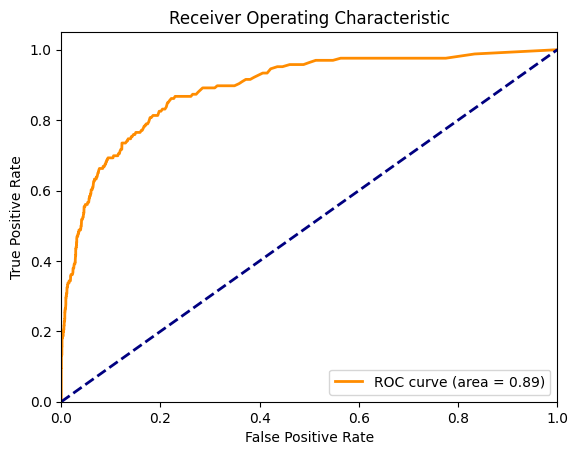

In [12]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Precision-Recall-AUC

In [13]:
precision, recall, _ = precision_recall_curve(y_test, prediction_probs)
pr_auc = auc(recall, precision)

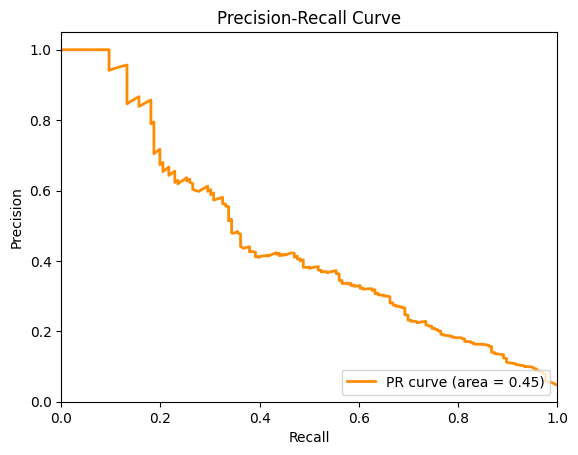

In [14]:
# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

### Confusion Matrix

In [15]:
conf_matrix = confusion_matrix(y_test, predictions)
print(conf_matrix)

[[3365    3]
 [ 144   22]]


# XAI METHODS 
## Modify

In [70]:
model.predict(X_test) == 1

array([False, False, False, ..., False, False, False])

In [63]:
# General
# sample = X_test[y_test == 1].iloc[1] # Sample to investigate better, choose sample with positive outcome
sample = X_test[y_test == 1 and model.predict(X_test) == 1].iloc[1] # Sample to investigate better, choose sample with positive outcome

# PDP & ICE
features_pdp = ['Age', 'Need_of_Care_Duration'] # [(0, 1)] -> For 2-dimensional plot
show_pdp = True
resolution_pdp = 100 # Granularity of PDP & ICE plot (how often to split the x-axis)

# ALE 
features_ale = ['Age', 'Sex'] # [(0, 1)] -> For 2-dimensional plot

# Anchors
features_anc = ['Age', 'Sex'] # [(0, 1)] -> For 2-dimensional plot

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

## Utils

Get the indexes of the columns I want to investigate. 

In [17]:
def get_features_idx(feature_names):
    features_idx = list()
    for feature_group in feature_names:
        if type(feature_group) == str:
            features_idx.append(X_test.columns.get_loc(feature_group))
        else:
            feature_group_idx = [X_test.columns.get_loc(feat) for feat in feature_group]
            features_idx.append(tuple(feature_group_idx))
    return features_idx

## PDP & ICE
Shortcomings: 

- Through data generation it might be based on "impossible" samples (can be prevented partly by conditional instead of marginal probability), data that was not included in the training data (which contains real data) -> thus predictions are not meaningful -> However, this might also help in assessing the generalizability of the model: Does it also perform well in former unknown/unseen samples? -> Robustness 
- Limited informative value for correlated features (because )

#### Modify

In [18]:
# features_pdp = [('Age', 'Need_of_Care_Duration')] # [(0, 1)] -> For 2-dimensional plot
# show_pdp = True
# resolution = 25 # Granularity of PDP & ICE plot (how often to split the x-axis)
# sample = X_test.iloc[1] # Sample to investigate better

Create the explainer.

In [19]:
kind = 'average' if show_pdp else 'both'
features_idx_pdp = get_features_idx(features_pdp)
def predict_fn_pdp(data):
    # TODO: Check if this indexing of x makes sense 
    return model.predict(data)

pdp = PartialDependence(predictor=predict_fn_pdp,
                        feature_names=predictors,
                        target_names=[target])

exp_pdp_ice = pdp.explain(X=X_test.values,
                  features=features_idx_pdp,
                  kind=kind,
                  grid_resolution=resolution_pdp)

c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassi

Plot the PDP & ICE

array([[<Axes: xlabel='Age', ylabel='HC_Patient_Next_Year'>,
        <Axes: xlabel='Need_of_Care_Duration', ylabel='HC_Patient_Next_Year'>]],
      dtype=object)

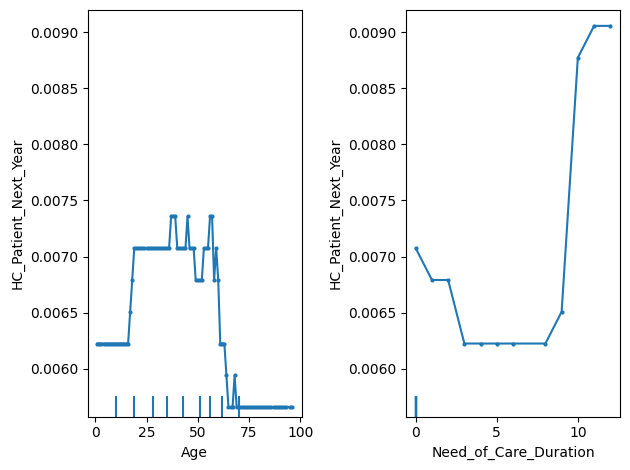

In [20]:
# fig, axis = plt.subplots()
# axis.set_ylim([0, 0.02])

# plt.ylim(0, 0.05)
plot_pd(exp_pdp_ice,
        # n_cols=2,
        sharey='row',
        # ax=axis,
        center=show_pdp)

## ALE
Measures the *differences in prediction* instead of directly averaging over predictions like pdp [here](https://docs.seldon.io/projects/alibi/en/latest/methods/ALE.html)

ALE and PDP (and probably also ICE) are methods to retrieve the *feature effects* for each feature.

#### Modify

In [21]:
# features_ale = ['Age', 'Sex'] # [(0, 1)] -> For 2-dimensional plot
# resolution = 25 # Granularity of PDP & ICE plot (how often to split the x-axis)
# sample = X_test.iloc[1] # Sample to investigate better

In [22]:
def predict_fn_ale(x):
    return model.predict(x)

c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassi

array([[<Axes: xlabel='Age', ylabel='ALE'>,
        <Axes: xlabel='Sex', ylabel='ALE'>]], dtype=object)

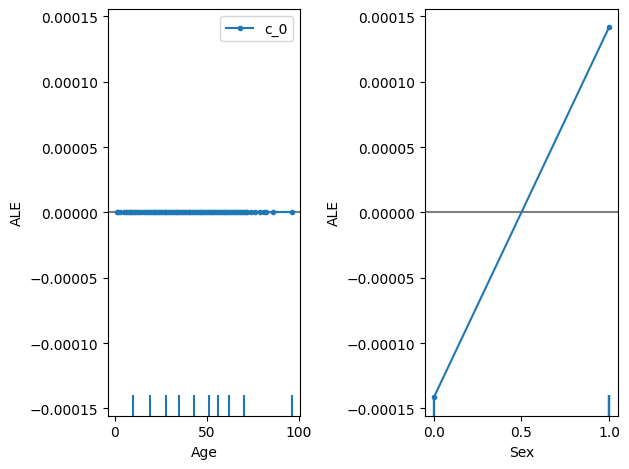

In [23]:
features_idx_ale = get_features_idx(features_ale)

ale = ALE(predict_fn_ale, feature_names=predictors)
exp_ale = ale.explain(X_test.to_numpy(), features=features_idx_ale)
plot_ale(exp_ale, features=features_ale)

## Anchors

In [24]:
# features_anc = ['Age', 'Sex'] # [(0, 1)] -> For 2-dimensional plot
# show_pdp = True
# resolution = 25 # Granularity of PDP & ICE plot (how often to split the x-axis)
# sample = X_test.iloc[1] # Sample to investigate better

Get the indexes of the columns I want to investigate. 

In [25]:
def predict_fn_anchors(x):
    return model.predict(x)

In [26]:
features_idx_anc = get_features_idx(features_anc)

exp_anchors = AnchorTabular(predict_fn_anchors, feature_names=predictors)
exp_anchors.fit(X_train.values, disc_perc=(10, 25, 40, 50, 60, 75, 90))

c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassi

In [51]:
res_anchors = exp_anchors.explain(sample.values, threshold=0.98)

c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassi

In [62]:
print('Prediction: ', predict_fn_ale(sample.values.reshape(1, -1)))
print('Anchor:', res_anchors.anchor)
print('Precision: ', res_anchors.precision)
print('Coverage: ', res_anchors.coverage)

Prediction:  [0]
Anchor: ['Outpatient_C43 <= 0.00']
Precision:  0.9864864864864865
Coverage:  0.9838


c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
